# Testing performance of different shrinkage techniques
This corresponds to the performance experiments in section 4 of Agarwal et al. 2022.

In [4]:
import sys
sys.path.append('../')  # Necessary to import aughs from parent directory

from imodels.util.data_util import get_clean_dataset
import numpy as np
from aughs import ShrinkageClassifier, ShrinkageRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

## Classification

In [6]:
def compute_scores_single_fold_clf(train_index, test_index, X, y, lmbs, shrink_mode):
    scores = []

    clf = ShrinkageClassifier(shrink_mode=shrink_mode)
    clf.fit(X[train_index], y[train_index])
    for lmb in lmbs:
        clf.set_shrink_params(X[train_index], shrink_mode=shrink_mode, lmb=lmb)
        scores.append(balanced_accuracy_score(y[test_index], clf.predict(X[test_index])))
    return scores

In [7]:
clf_datasets = [
    ("heart", "heart", "imodels"),
    ("breast-cancer", "breast_cancer", "imodels"), 
    ("haberman", "haberman", "imodels"), 
    ("ionosphere", "ionosphere", "pmlb"),
    ("diabetes-clf", "diabetes", "pmlb"),
    ("german", "german", "pmlb"),
    ("juvenile", "juvenile_clean", "imodels"),
    #("recidivism", "compas_two_year_clean", "imodels")
]

<>:22: DeprecationWarning: invalid escape sequence '\l'
<>:22: DeprecationWarning: invalid escape sequence '\l'
/tmp/ipykernel_36463/3640589435.py:22: DeprecationWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


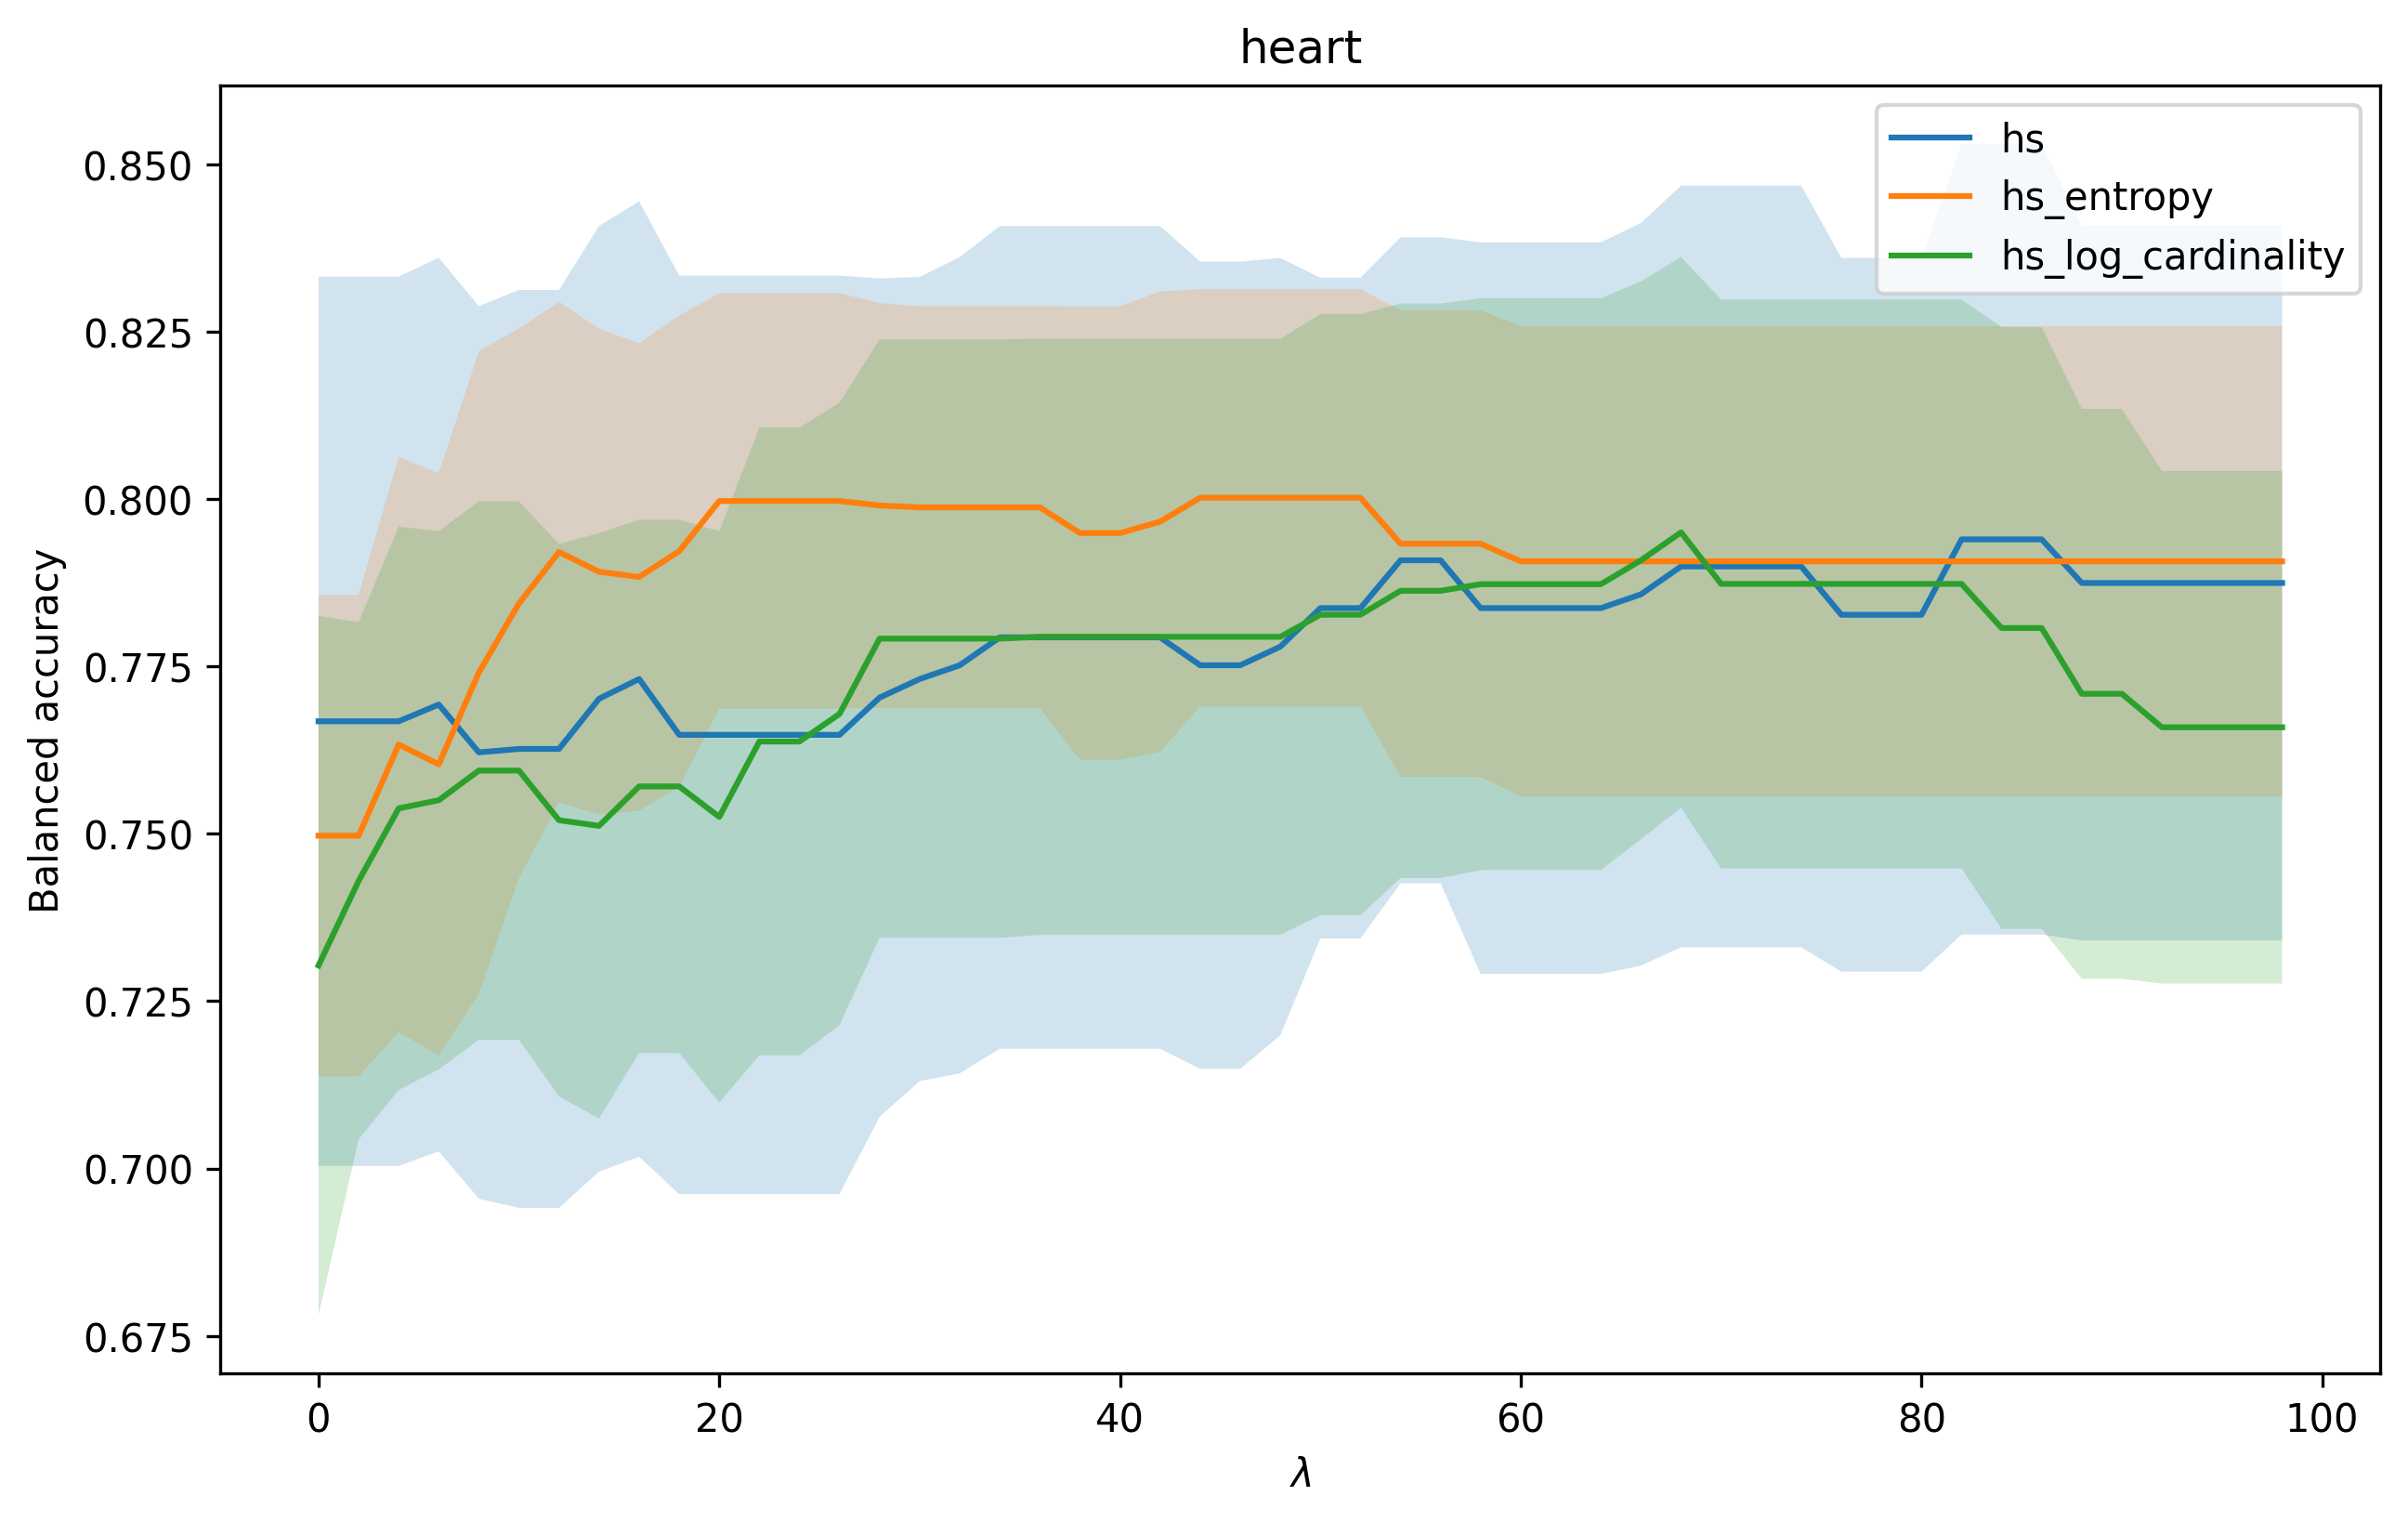

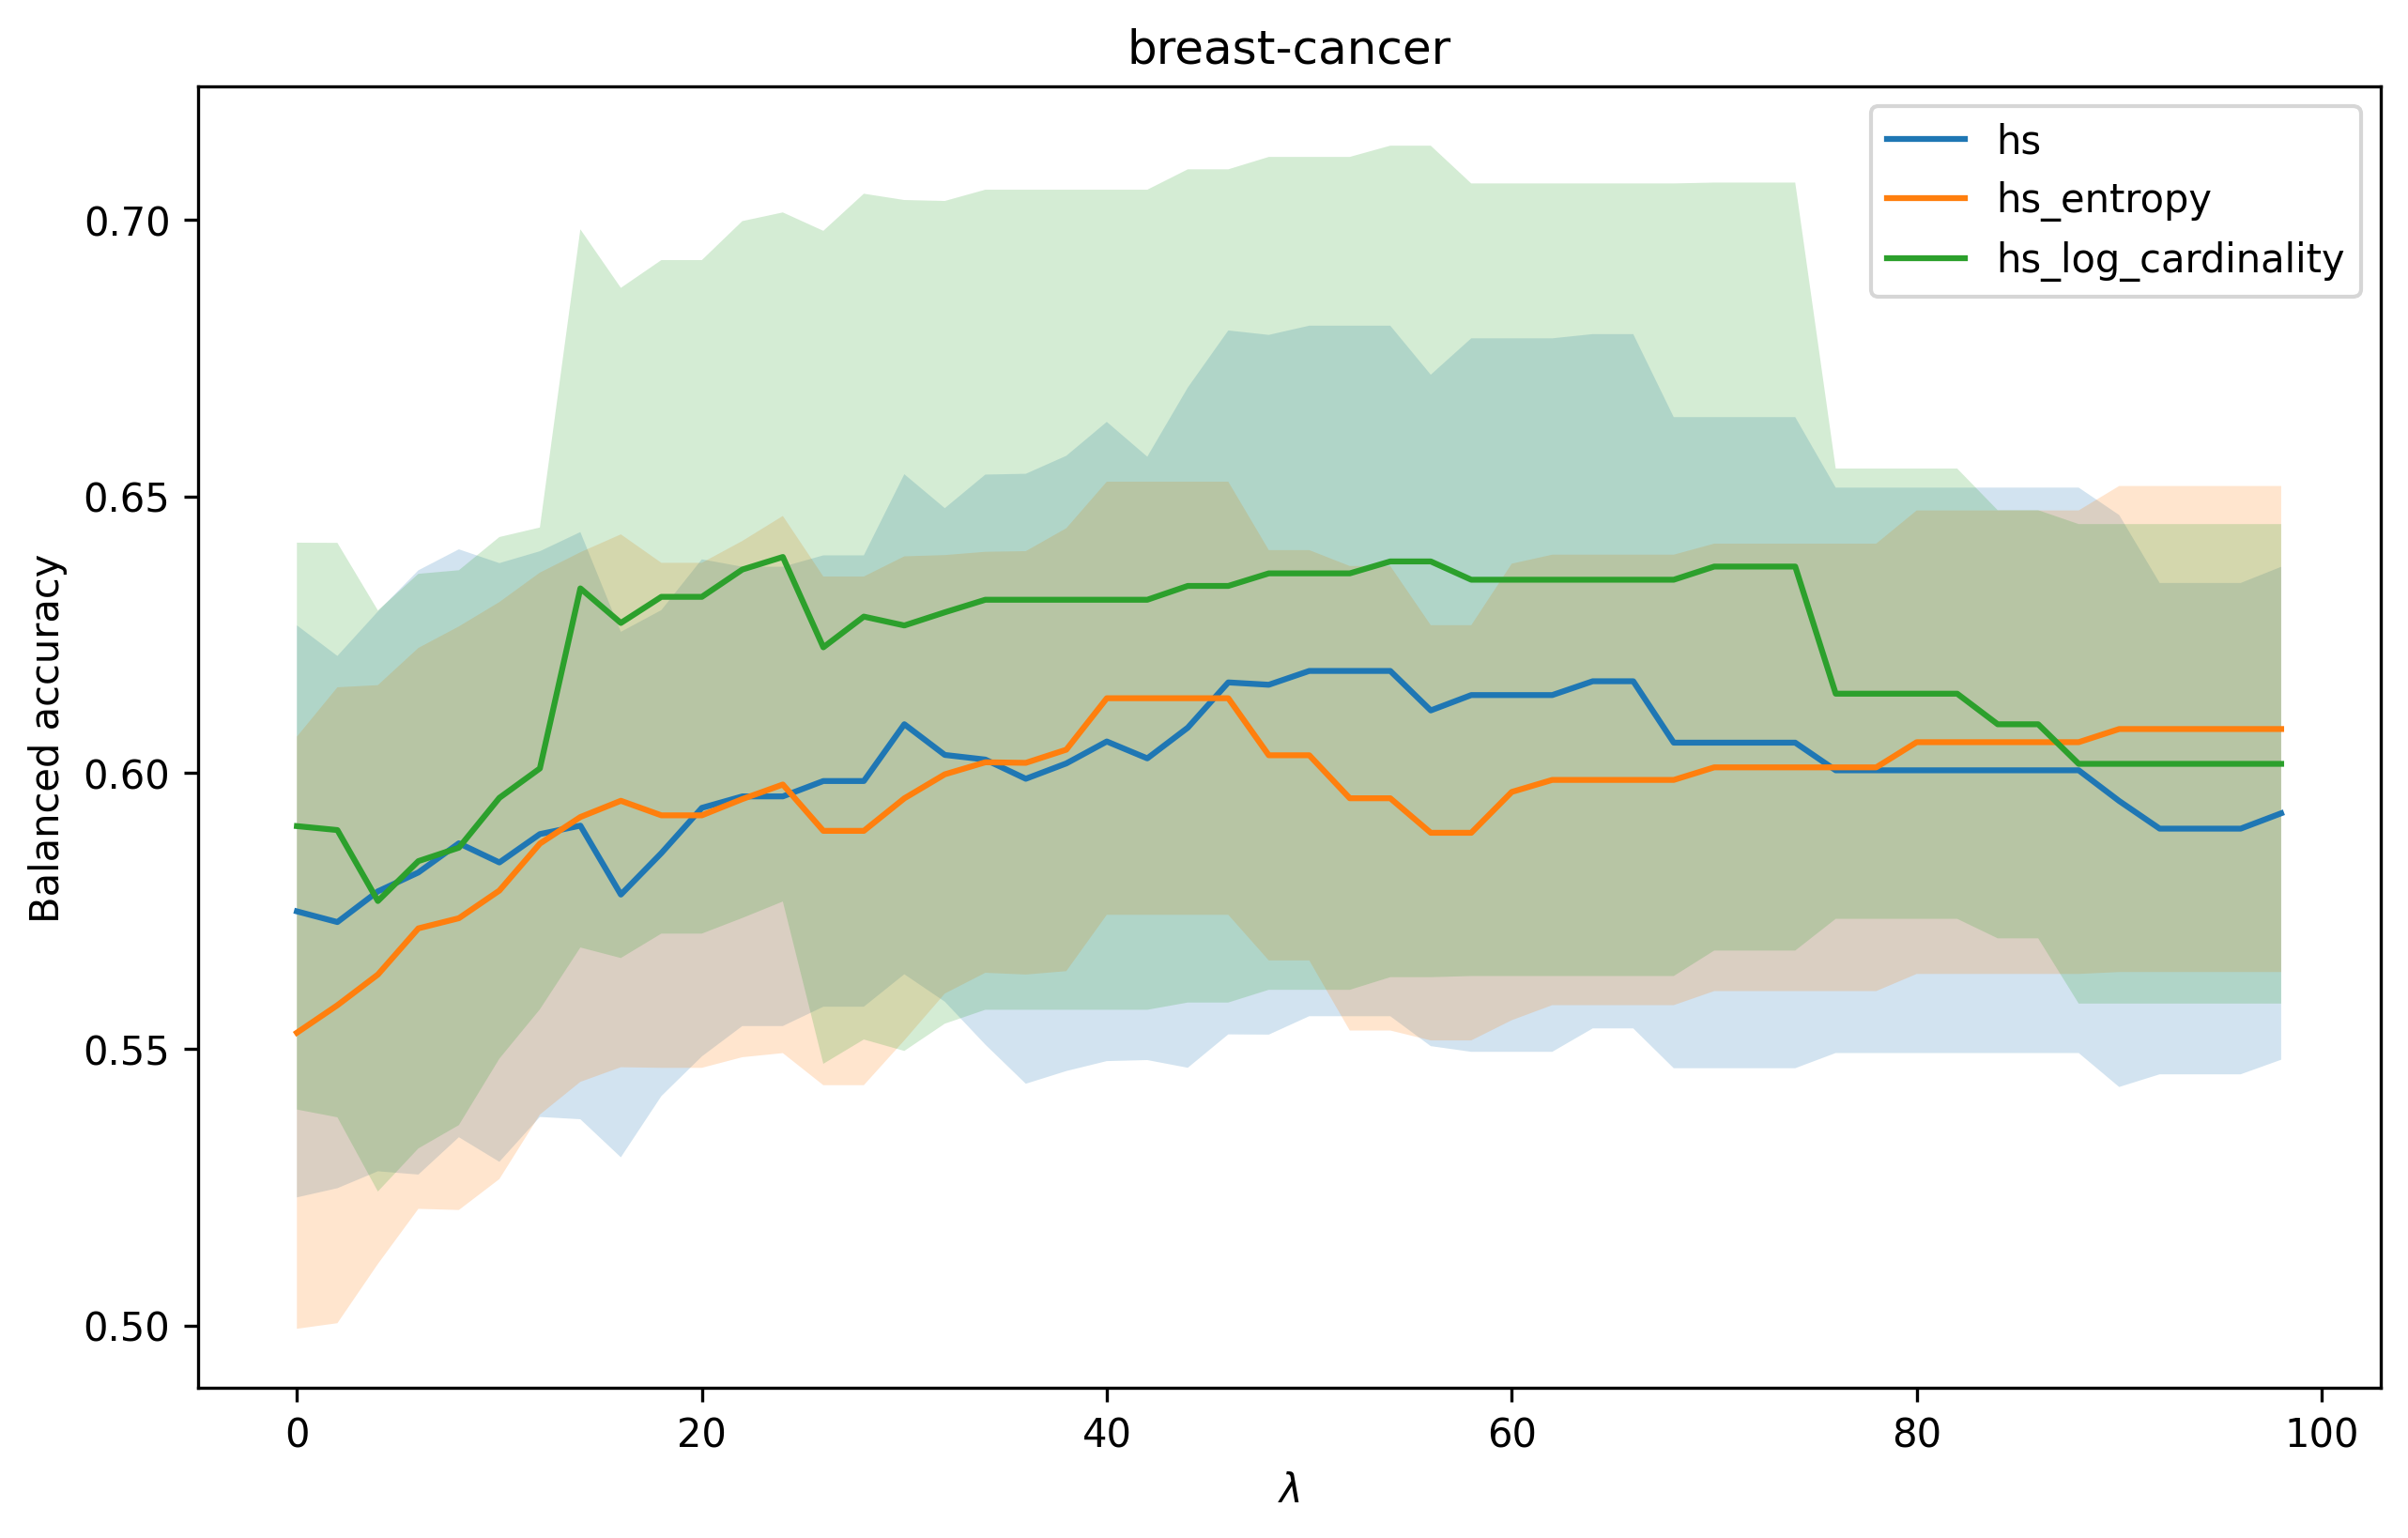

/tmp/ipykernel_36463/3640589435.py:22: DeprecationWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


KeyboardInterrupt: 

In [10]:
lmbs = np.arange(0, 100, 2)
for ds_name, id, source in clf_datasets:
    X, y, feature_names = get_clean_dataset(id, data_source=source)
    scores = {}
    for shrink_mode in ["hs", "hs_entropy", "hs_log_cardinality"]:
        cv = KFold(n_splits=10, shuffle=True)
        results = Parallel(n_jobs=-1)(delayed(
            compute_scores_single_fold_clf)(
                train_index, test_index, X, y, lmbs, shrink_mode) 
                for train_index, test_index in cv.split(X))
        scores[shrink_mode] = np.vstack(results)
    
    plt.figure(figsize=(10, 6))
    for key in scores:
        avg = np.mean(scores[key], axis=0)
        std = np.std(scores[key], axis=0)
        n = scores[key].shape[0]
        conf = (1.96 * std / np.sqrt(n))
        plt.plot(lmbs, avg, label=key)
        plt.fill_between(lmbs, avg-conf, avg+conf, alpha=0.2)
    plt.legend()
    plt.xlabel("$\lambda$")
    plt.ylabel("Balanced accuracy")
    plt.title(ds_name)
    plt.show()


## Regression

In [11]:
reg_datasets = [
    ("friedman1", "friedman1", "synthetic"),
    ("friedman3", "friedman3", "synthetic"),
    ("diabetes-reg", "diabetes", "sklearn"),
    ("abalone", "183", "openml"),
    ("satellite-image", "294_satellite_image", "pmlb"),
    ("california-housing", "california_housing", "sklearn")
]

In [12]:
def compute_scores_single_fold_reg(train_index, test_index, X, y, lmbs, shrink_mode):
    scores = []

    clf = ShrinkageRegressor(shrink_mode=shrink_mode)
    clf.fit(X[train_index], y[train_index])
    for lmb in lmbs:
        clf.set_shrink_params(X[train_index], shrink_mode=shrink_mode, lmb=lmb)
        scores.append(mean_squared_error(y[test_index], clf.predict(X[test_index])))
    return scores

<>:20: DeprecationWarning: invalid escape sequence '\l'
<>:20: DeprecationWarning: invalid escape sequence '\l'
/tmp/ipykernel_12480/2483331563.py:20: DeprecationWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


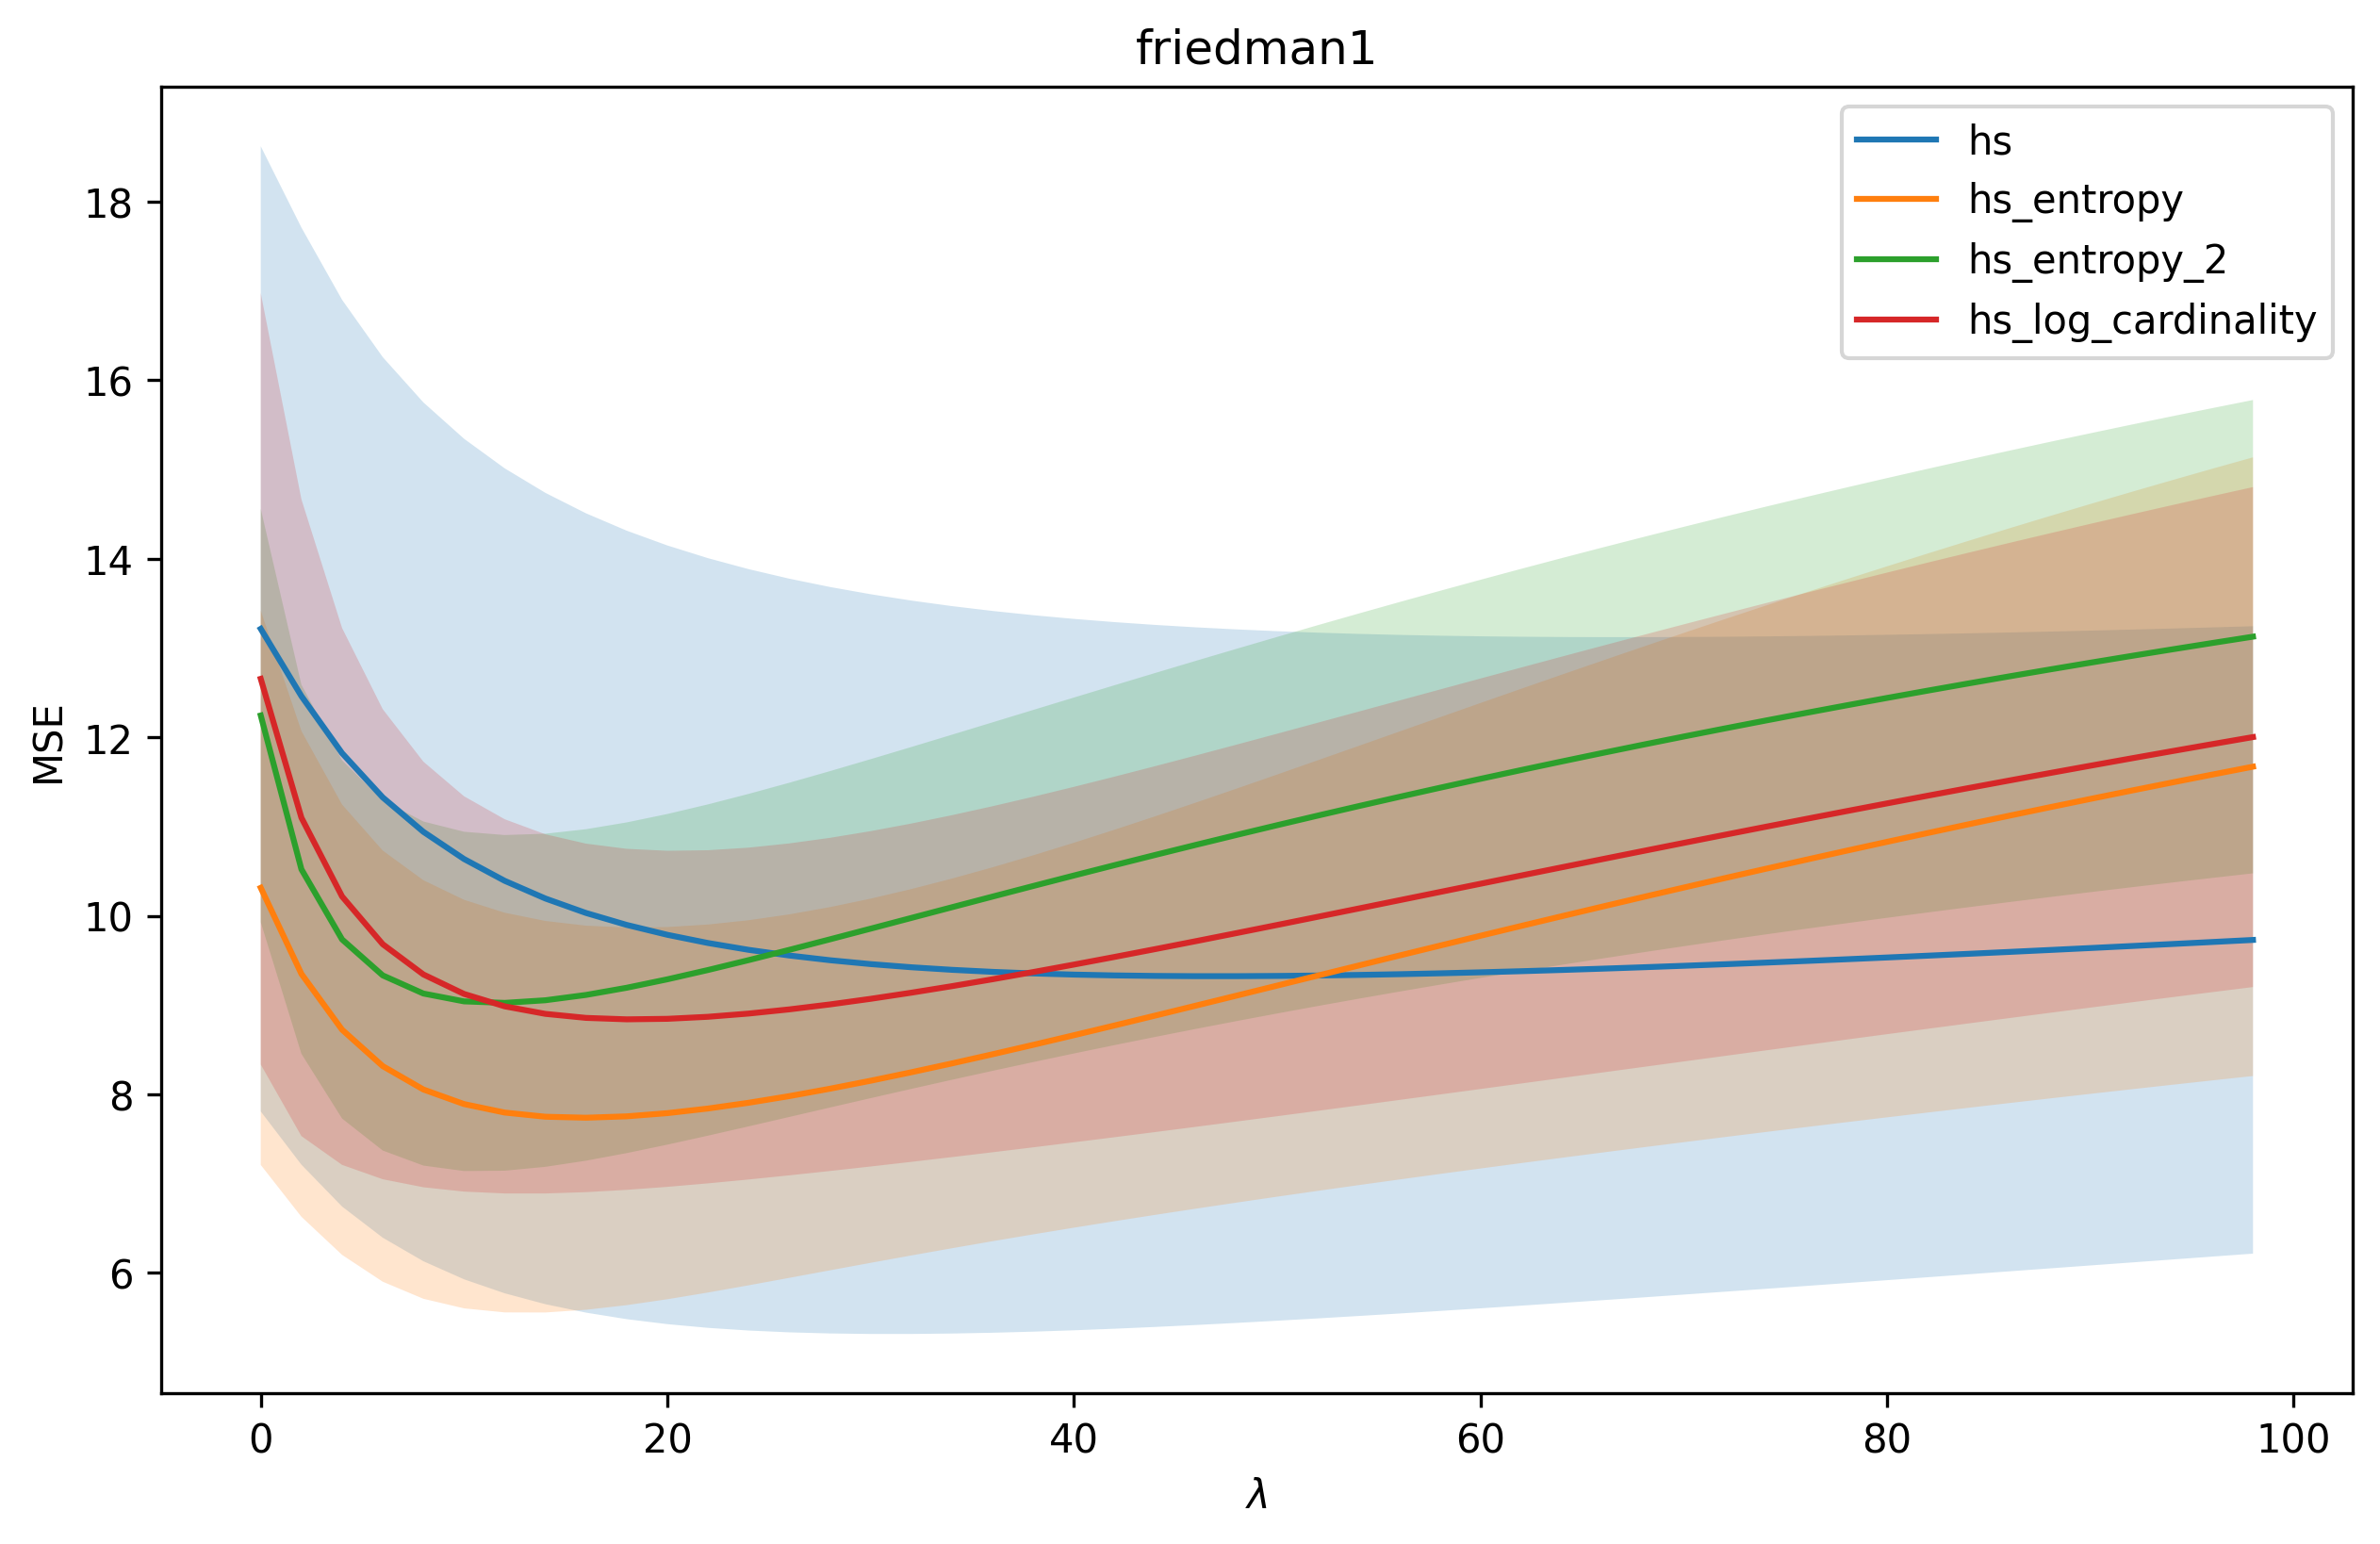

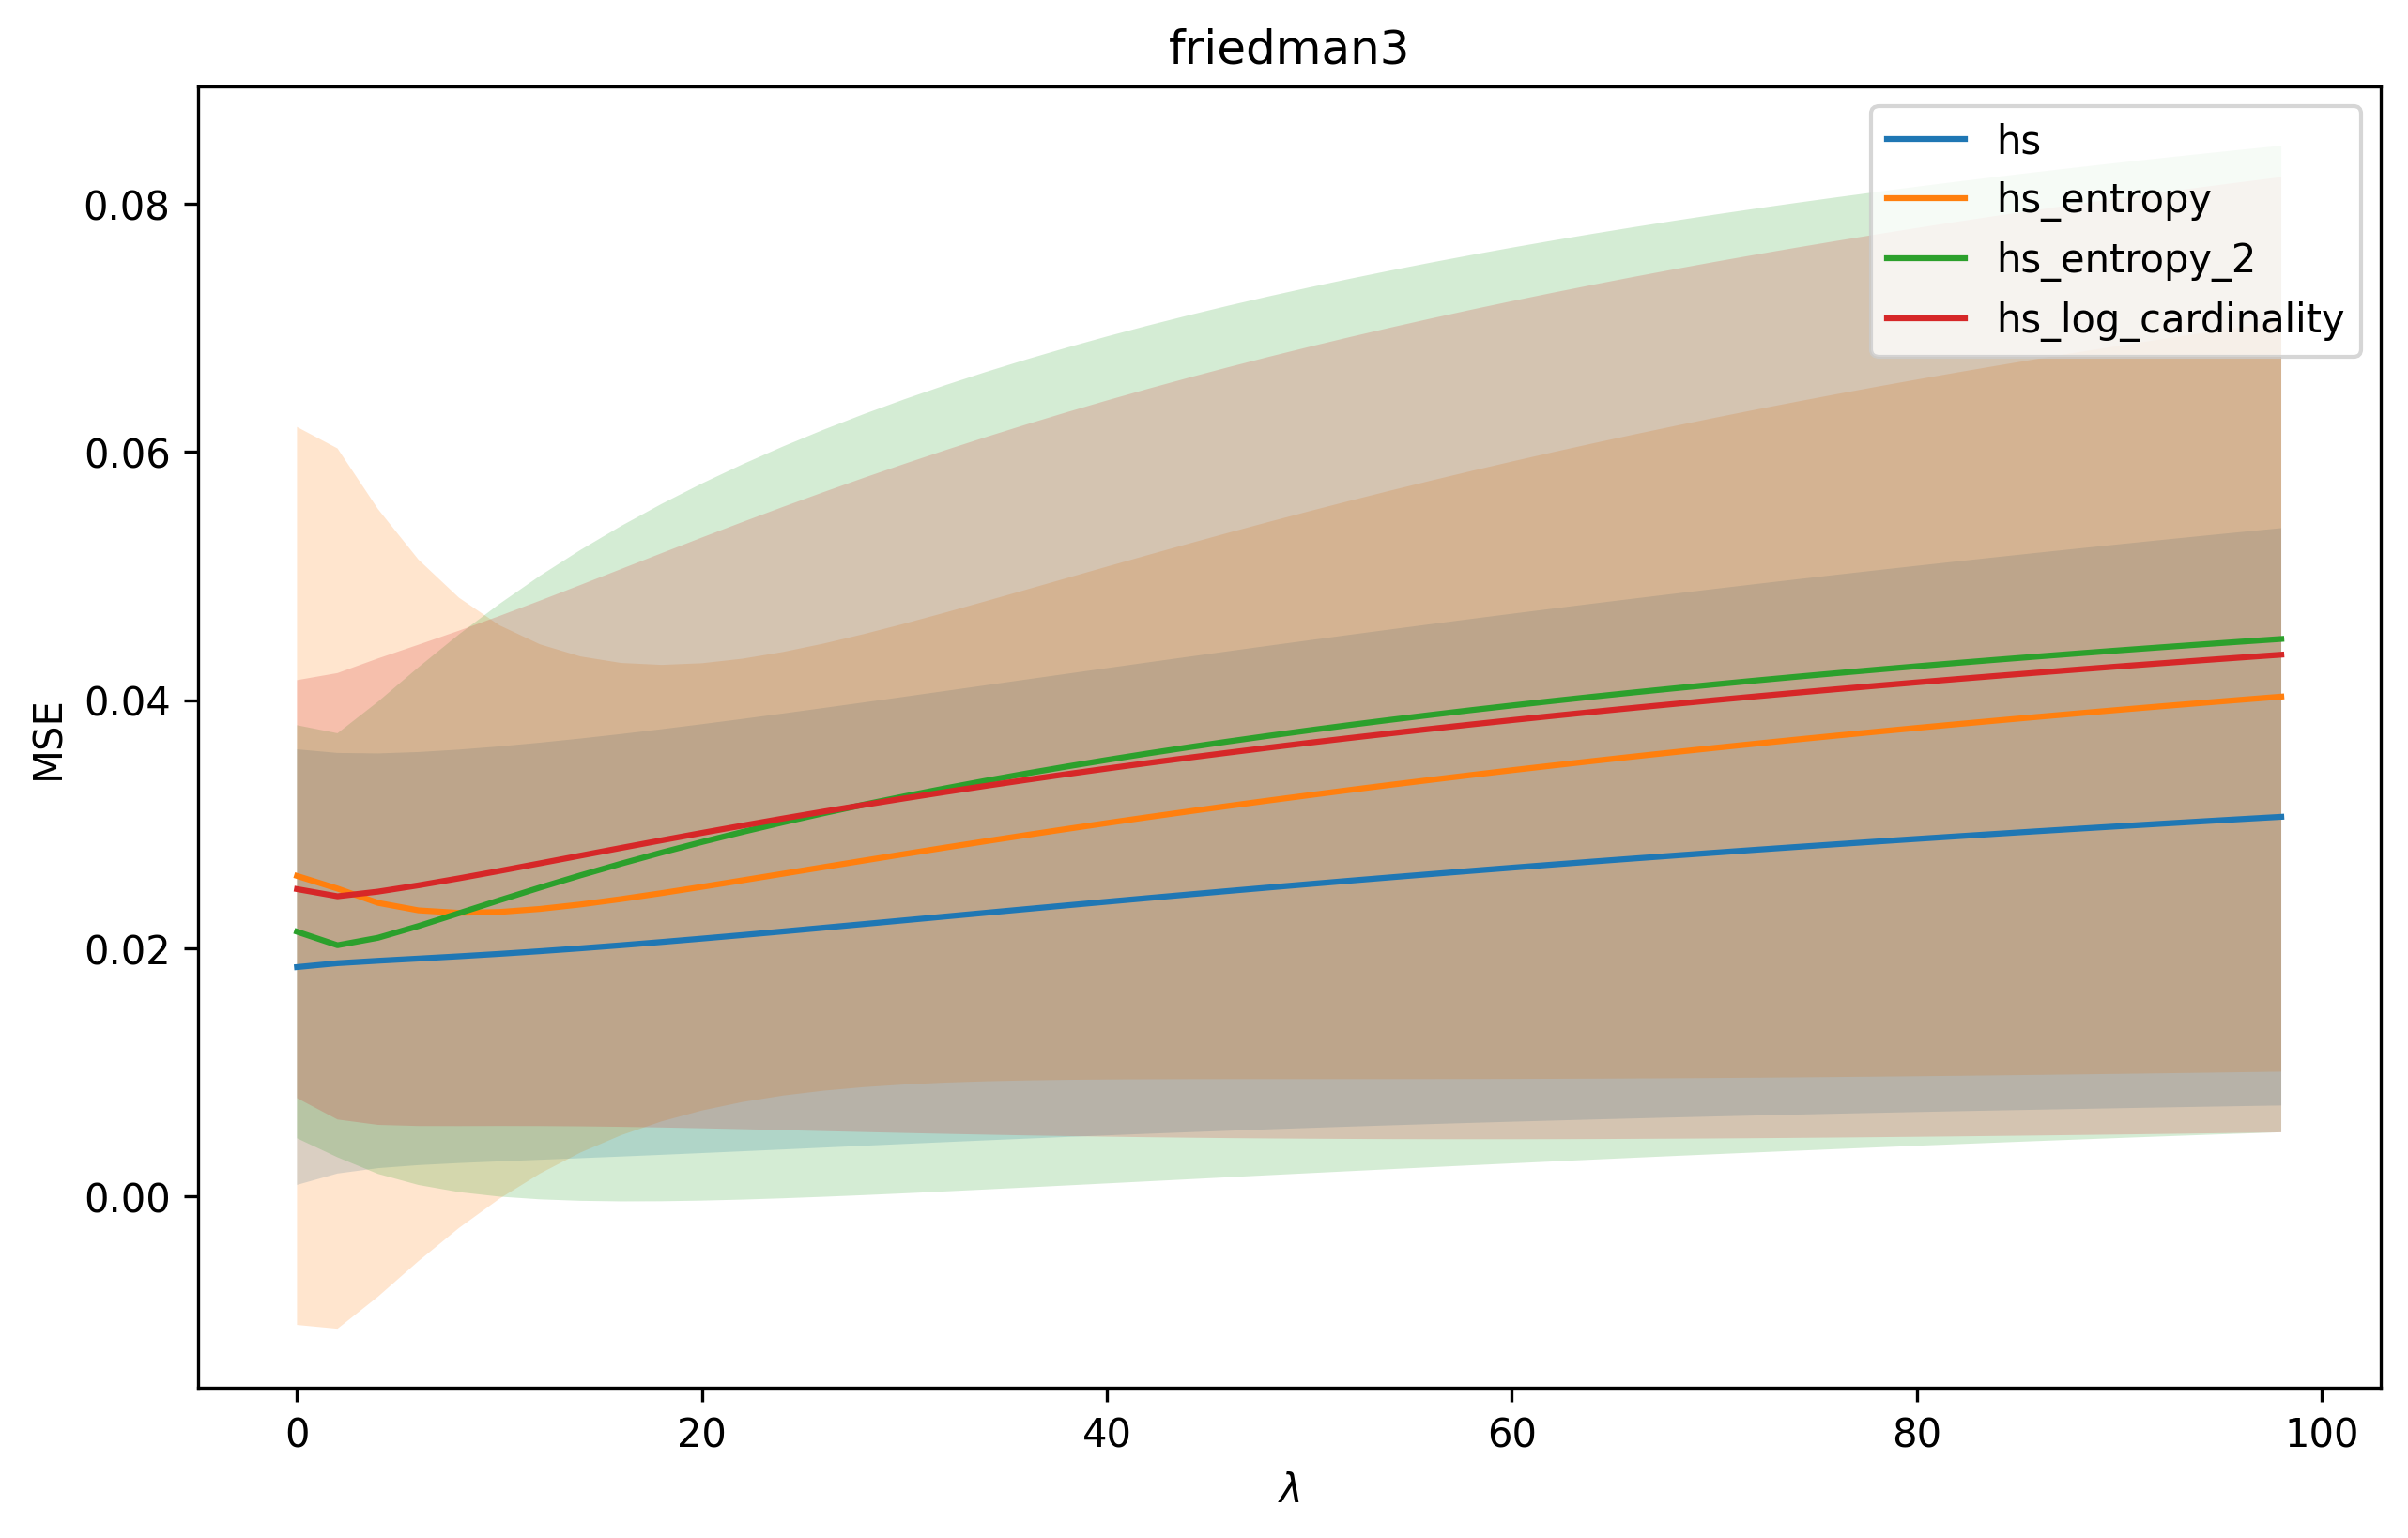

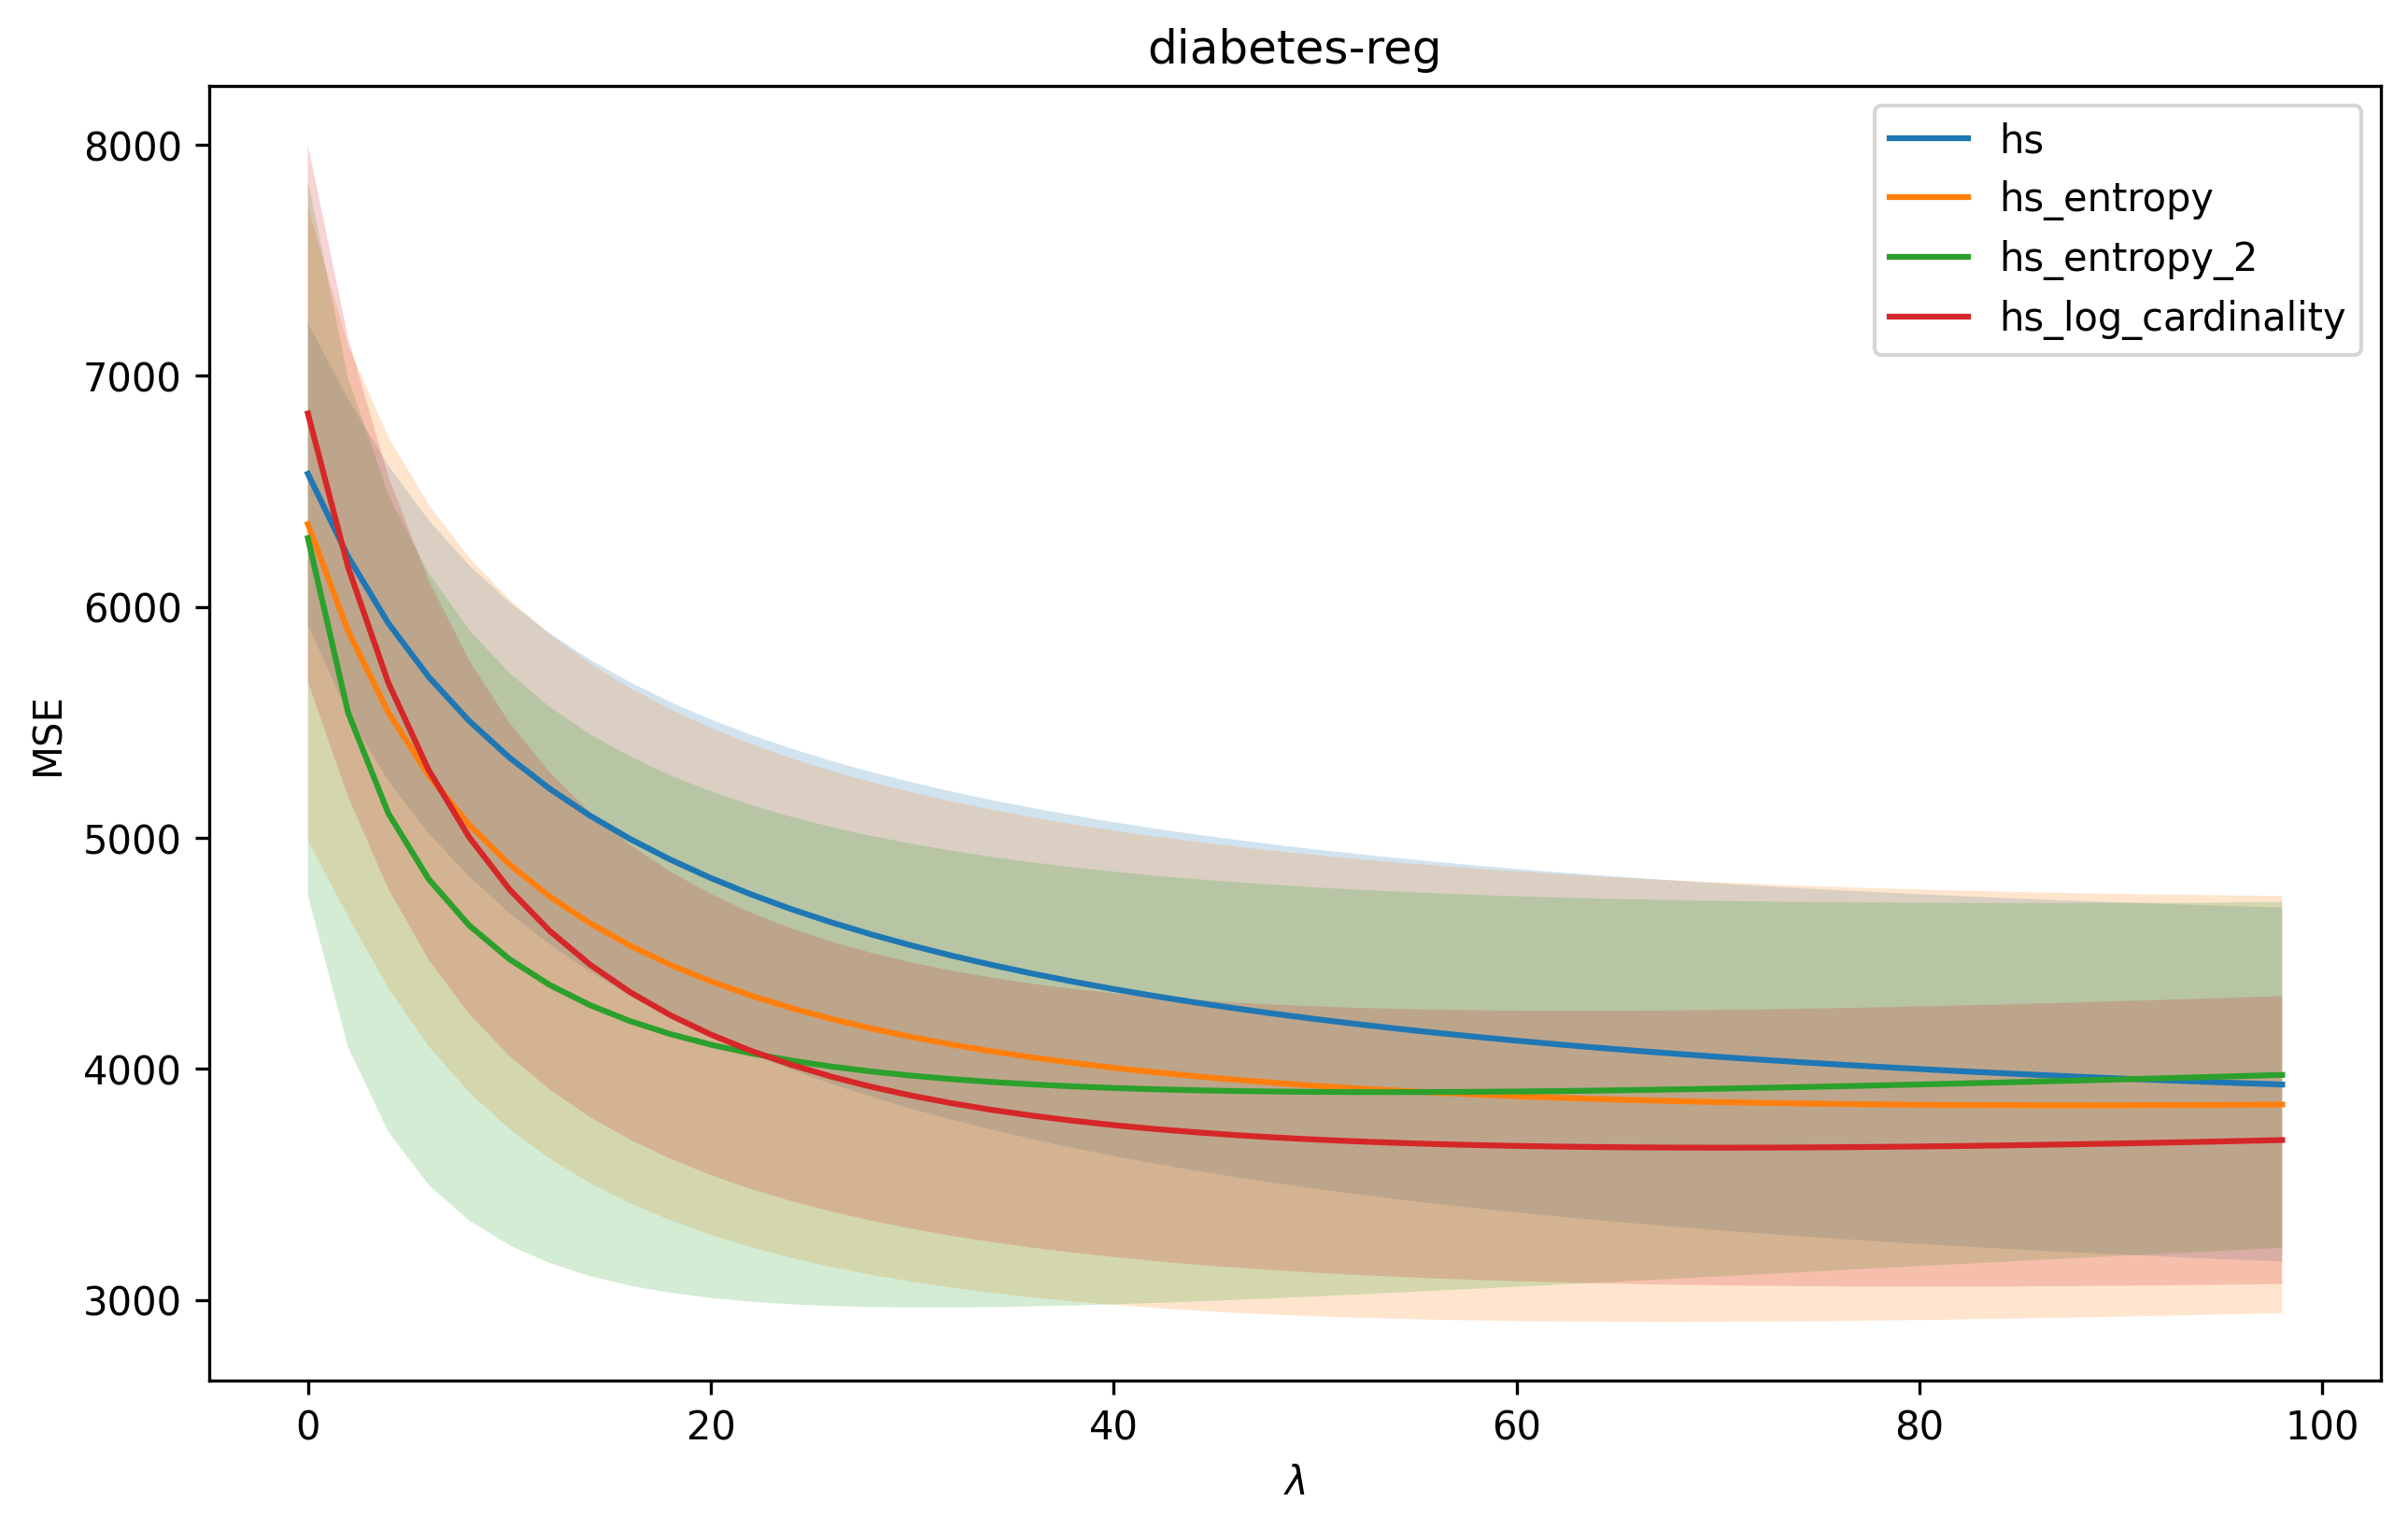

/home/arne/miniconda3/envs/hierarchical-shrinkage/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


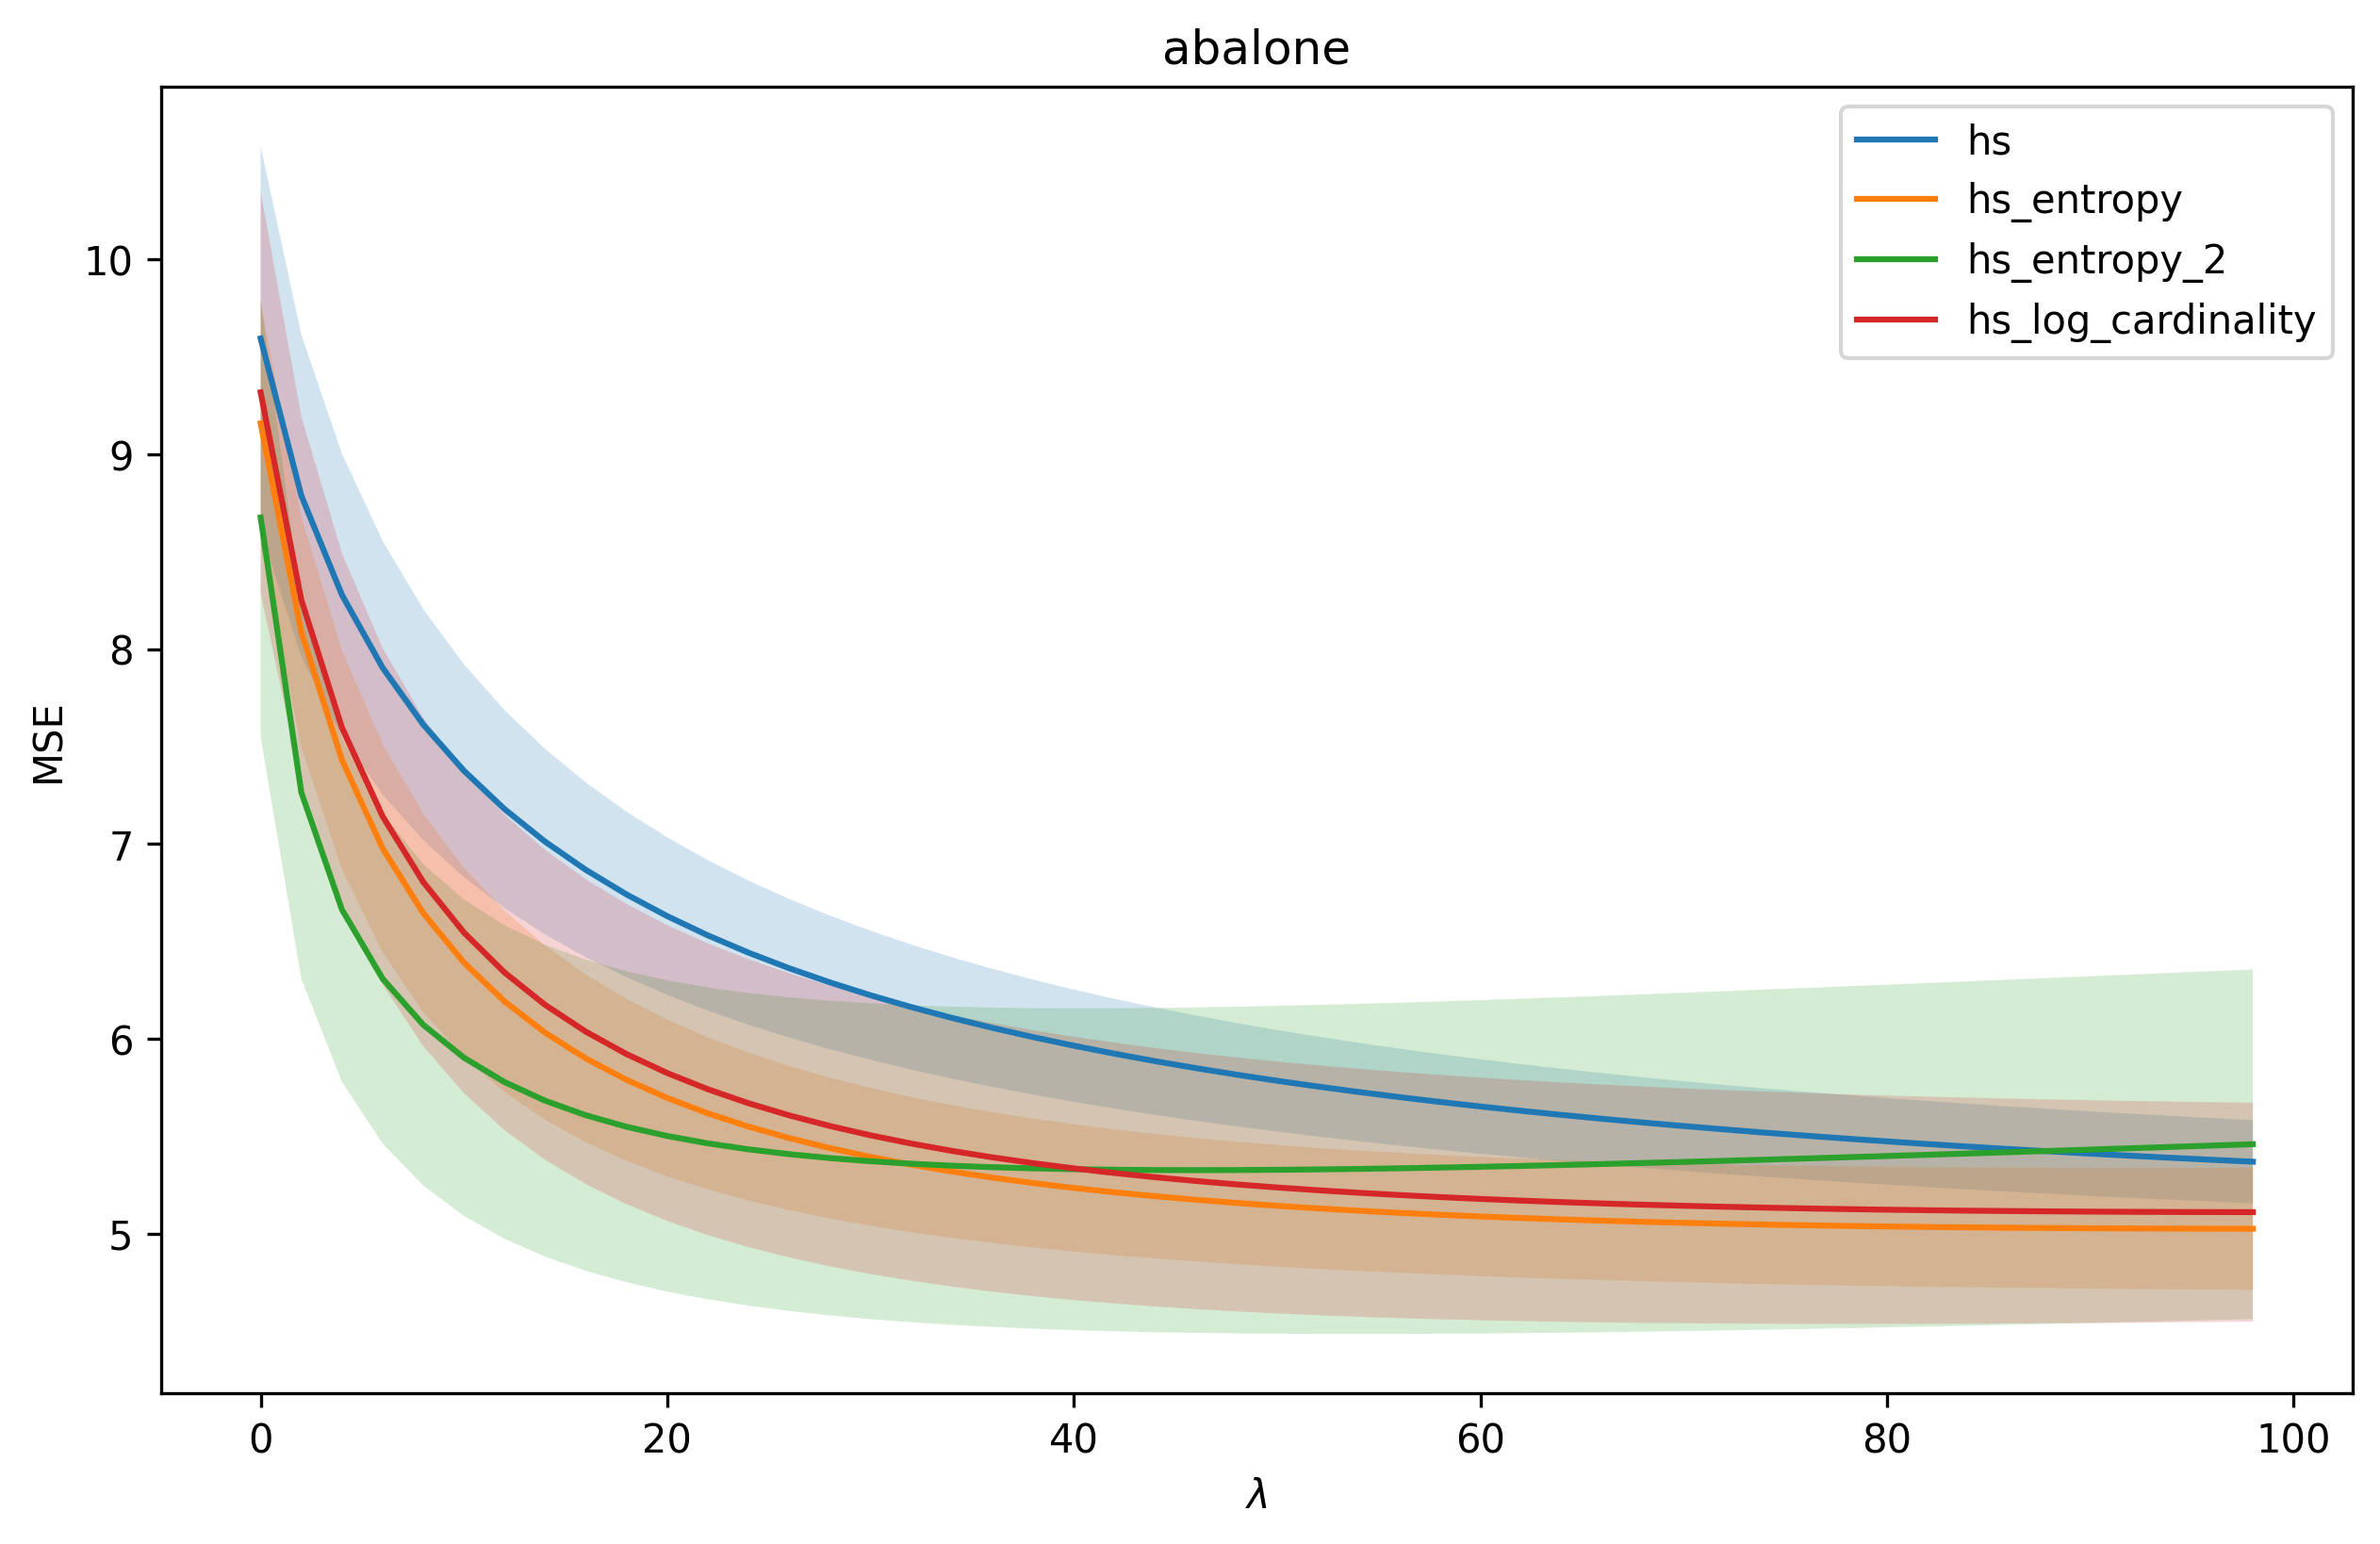

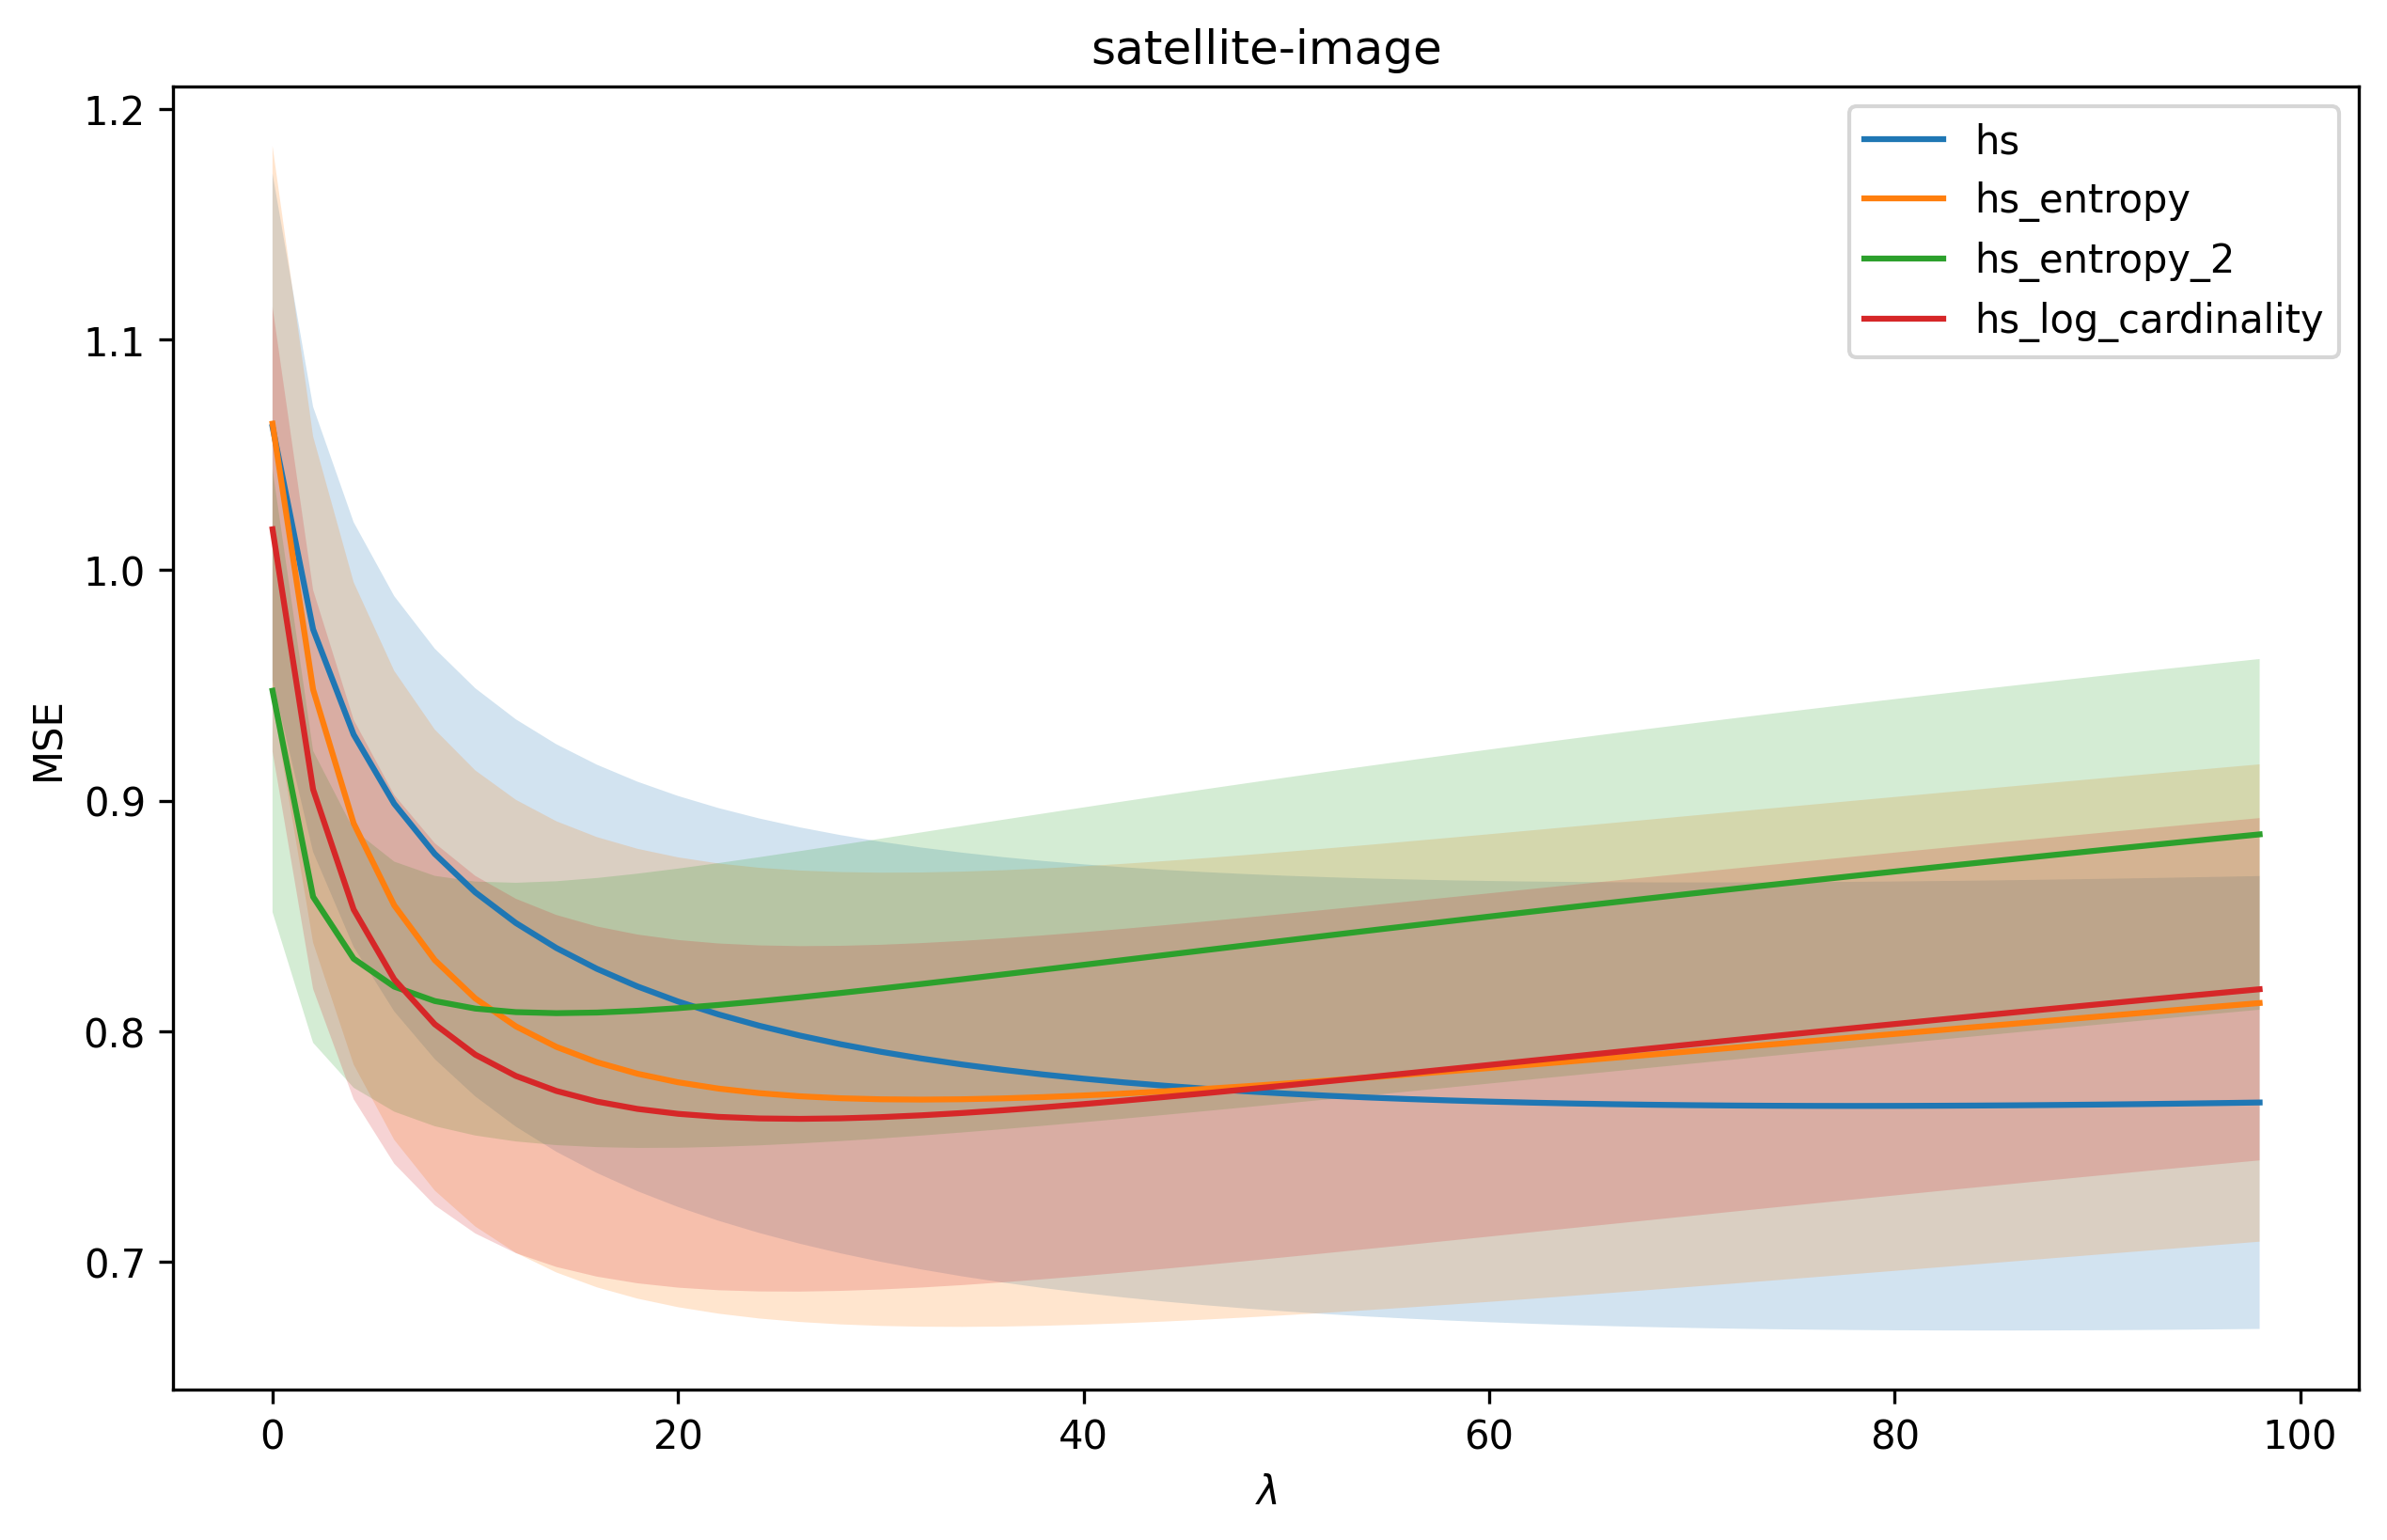

KeyboardInterrupt: 

In [15]:
lmbs = np.arange(0, 100, 2)
for ds_name, id, source in reg_datasets:
    X, y, feature_names = get_clean_dataset(id, data_source=source)
    scores = {}
    for shrink_mode in ["hs", "hs_entropy", "hs_log_cardinality"]:
        cv = KFold(n_splits=10, shuffle=True)
        results = Parallel(n_jobs=-1)(delayed(
            compute_scores_single_fold_reg)(
                train_index, test_index, X, y, lmbs, shrink_mode) 
                for train_index, test_index in cv.split(X))
        scores[shrink_mode] = np.vstack(results)
    
    plt.figure(figsize=(10, 6))
    for key in scores:
        avg = np.mean(scores[key], axis=0)
        std = np.std(scores[key], axis=0)
        plt.plot(lmbs, avg, label=key)
        plt.fill_between(lmbs, avg-std, avg+std, alpha=0.2)
    plt.legend()
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")
    plt.title(ds_name)
    plt.show()
